In [13]:
# Generate the enrcihed_data.csv dataset that is used for topic modelling experiments.
# Combines app store data with app store data fetched from the App Store using
# the iTunes API.

import json
import pandas as pd
import os
import re
import requests
import csv
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from gensim.parsing.preprocessing import remove_stopwords, strip_punctuation, strip_numeric, strip_short, strip_tags

DEBUG = False


In [14]:
if not DEBUG:
    df = pd.read_csv('appleAppData.csv')


In [15]:
if DEBUG:
    # create a smaller sample of 1% of the original rows for development purposes
    !head -1 appleAppData.csv > sample.csv
    !awk 'BEGIN  {srand()} !/^$/  { if (rand() <= .01 || FNR==1) print >> "sample.csv"}' appleAppData.csv
    #
    #
    df = pd.read_csv('sample.csv')

    df.columns


In [16]:
# Filter games only from the dataset
df = df.query("Primary_Genre == 'Games'")
df = df.dropna()
# Drop unneeded columns
df = df.drop(['Primary_Genre', 'Size_Bytes', 'Required_IOS_Version', 'Version', 'Price', 'Currency', 'Developer','Developer_Url','Developer_Website', 'Current_Version_Score', 'Current_Version_Reviews'], axis=1)


In [17]:
# Extract the app store id that can be used for querying the App Store API
def extract_numeric_app_id(row):
    # The app store id is in the format '/id[0-9]{9}' at the end of the URL.
    # We only want the numeric part of the id, hence the ()'s
    matches = re.findall('id([0-9]{9})', row)
    if len(matches) == 0:
        print('No id found for row ', row)
        return None
    else:
        return matches[0]

df['AppStoreId'] = df['AppStore_Url'].apply(extract_numeric_app_id)
df['AppStoreId']


21         943274708
23         126382794
32         552864558
100        352871101
118        639537194
             ...    
1213920    377912125
1218816    124469544
1221824    154654196
1224010    154045177
1228531    128230260
Name: AppStoreId, Length: 82722, dtype: object

In [18]:
df.shape


(82722, 11)

In [19]:

def getGameDescription(appStoreId):
    itunesUrl = 'https://itunes.apple.com/lookup?id=' + str(appStoreId)
    fields = [None, None, None, None]
    body = None

    # Check local cache before doing a request
    cachePath = 'store_data/' + str(appStoreId) +'.json'
    if (os.path.isfile(cachePath)):
        f = open(cachePath)
        body = json.load(f)
    else:
        try:
            response = requests.get(itunesUrl)
            if (response.status_code == 200):
                body = json.loads(response.text)
                # write response to cache directory
                with open(cachePath, 'w') as outfile:
                    json.dump(body, outfile)
            else:
                if DEBUG: print ("Failed to retrieve results for " + str(appStoreId))
                return fields

        except requests.exceptions.Timeout:
            print('AppStore request timed out for ' + str(appStoreId))
            raise SystemExit(e)
        except requests.exceptions.RequestException as e:
            # catastrophic error. bail.
            raise SystemExit(e)

    if (body['resultCount'] == 1 ):
        result = body['results'][0]
        if ('genreIds' in result and 'description' in result):
            fields = [
                result['genres'], # appStoreGenres
                result['genreIds'], # appStoreGenreIds
                result['description'], # Description
                result['languageCodesISO2A'], # GameLanguages
            ]
        else:
            if DEBUG: print ('Unexpected results')
            if DEBUG: print (body)
    else:
        if DEBUG: print ("No results found for id " + str(appStoreId))
        return fields

    return fields

df[['AppStoreGenres', 'AppStoreGenreIds', 'Description', 'GameLanguages']] = df.apply(lambda x : getGameDescription(x['AppStoreId']), axis='columns', result_type='expand')
df['AppName'] = df['App_Name'] # normalize the naming
df = df.dropna()
df

# TODO drop unnecessary columns and finalize the column names


,App_Id,App_Name,AppStore_Url,Content_Rating,Released,Updated,Free,DeveloperId,Average_User_Rating,Reviews,AppStoreId,AppStoreGenres,AppStoreGenreIds,Description,GameLanguages,AppName
21,com.alpigames.fairylandpuzzle,AAA³ Little Ponies & Unicorns,https://apps.apple.com/us/app/aaa-little-ponie...,4+,2014-12-05T08:00:00Z,2016-03-12T15:09:55Z,True,419456907,5.00000,1,943274708,"[Games, Role Playing, Adventure, Books]","[6014, 7014, 7002, 6018]",Welcome to the land of fairies in this puzzle ...,"[AR, CA, HR, CS, DA, NL, EN, FI, FR, DE, EL, H...",AAA³ Little Ponies & Unicorns
32,com.jhdigitalsolutions.lastenaakkoset,Aakkospeli Lapsille,https://apps.apple.com/us/app/aakkospeli-lapsi...,4+,2012-08-22T20:32:46Z,2015-10-11T14:06:03Z,False,481610881,5.00000,1,552864558,"[Games, Family, Books]","[6014, 7009, 6018]",Opi aakkosia hauskalla tavalla lasten aakkospe...,[FI],Aakkospeli Lapsille
100,au.com.tinmangames.gamebookvolume1,GA1: An Assassin in Orlandes,https://apps.apple.com/us/app/ga1-an-assassin-...,12+,2010-02-08T08:00:00Z,2017-09-24T04:49:53Z,False,318996102,3.20000,5,352871101,"[Games, Books, Role Playing]","[6014, 6018, 7014]",An interactive fantasy adventure! It's a book....,[EN],GA1: An Assassin in Orlandes
118,de.concapptmedia.0056iPhoneKidsComputer,Baby Games App (by HAPPYTOUCH®),https://apps.apple.com/us/app/baby-games-app-b...,4+,2013-05-07T07:00:00Z,2017-09-06T16:38:11Z,True,447370352,5.00000,1,639537194,"[Games, Books, Family]","[6014, 6018, 7009]","There's plenty to press, touch, move and explo...",[EN],Baby Games App (by HAPPYTOUCH®)
242,de.concapptmedia.0008iPadKidsComputer,Baby Games from HAPPYTOUCH®,https://apps.apple.com/us/app/baby-games-from-...,4+,2013-05-07T07:00:00Z,2017-05-25T00:43:39Z,True,447370352,5.00000,1,623194607,"[Games, Family, Books]","[6014, 7009, 6018]","There's plenty to press, touch, move and explo...",[EN],Baby Games from HAPPYTOUCH®
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1167789,com.detentiongames.hiddenobjectsusanewyorkflor...,Hidden Objects USA Time Object,https://apps.apple.com/us/app/hidden-objects-u...,4+,2015-02-21T08:00:00Z,2021-08-08T02:56:24Z,True,999167300,4.68966,29,966960359,"[Games, Puzzle, Travel, Role Playing]","[6014, 7012, 6003, 7014]",Vacation in the USA! Explore beautiful Travel ...,[EN],Hidden Objects USA Time Object
1168772,com.mQED.GoldenCherryMac,Slots! Golden Cherry,https://apps.apple.com/us/app/slots-golden-che...,17+,2013-06-27T02:18:13Z,2020-09-09T14:38:36Z,True,441029909,0.00000,0,664618541,"[Games, Simulation, Casino, Sports]","[6014, 7015, 7006, 6004]",The number 1 casino slot machine. It doesn't g...,[EN],Slots! Golden Cherry
1197497,de.udo-thiel.XAirport,XAirports,https://apps.apple.com/us/app/xairports/id5558...,4+,2012-09-26T17:51:02Z,2020-09-10T23:52:36Z,False,551147390,0.00000,0,555829723,"[Games, Simulation, Utilities]","[6014, 7015, 6002]",XAirports is a utility app that allows owner's...,[EN],XAirports
1203160,mx.com.bingware.QuickPad,QuickPad,https://apps.apple.com/us/app/quickpad/id71245...,4+,2013-10-08T15:01:00Z,2019-11-20T00:06:47Z,True,712451199,0.00000,0,712451196,"[Games, Casino, Utilities, Card]","[6014, 7006, 6002, 7005]",Esta aplicación es de uso exclusivo para salon...,[EN],QuickPad


In [20]:
print('Number of rows:', len(df))
df


Number of rows: 13387


,App_Id,App_Name,AppStore_Url,Content_Rating,Released,Updated,Free,DeveloperId,Average_User_Rating,Reviews,AppStoreId,AppStoreGenres,AppStoreGenreIds,Description,GameLanguages,AppName
21,com.alpigames.fairylandpuzzle,AAA³ Little Ponies & Unicorns,https://apps.apple.com/us/app/aaa-little-ponie...,4+,2014-12-05T08:00:00Z,2016-03-12T15:09:55Z,True,419456907,5.00000,1,943274708,"[Games, Role Playing, Adventure, Books]","[6014, 7014, 7002, 6018]",Welcome to the land of fairies in this puzzle ...,"[AR, CA, HR, CS, DA, NL, EN, FI, FR, DE, EL, H...",AAA³ Little Ponies & Unicorns
32,com.jhdigitalsolutions.lastenaakkoset,Aakkospeli Lapsille,https://apps.apple.com/us/app/aakkospeli-lapsi...,4+,2012-08-22T20:32:46Z,2015-10-11T14:06:03Z,False,481610881,5.00000,1,552864558,"[Games, Family, Books]","[6014, 7009, 6018]",Opi aakkosia hauskalla tavalla lasten aakkospe...,[FI],Aakkospeli Lapsille
100,au.com.tinmangames.gamebookvolume1,GA1: An Assassin in Orlandes,https://apps.apple.com/us/app/ga1-an-assassin-...,12+,2010-02-08T08:00:00Z,2017-09-24T04:49:53Z,False,318996102,3.20000,5,352871101,"[Games, Books, Role Playing]","[6014, 6018, 7014]",An interactive fantasy adventure! It's a book....,[EN],GA1: An Assassin in Orlandes
118,de.concapptmedia.0056iPhoneKidsComputer,Baby Games App (by HAPPYTOUCH®),https://apps.apple.com/us/app/baby-games-app-b...,4+,2013-05-07T07:00:00Z,2017-09-06T16:38:11Z,True,447370352,5.00000,1,639537194,"[Games, Books, Family]","[6014, 6018, 7009]","There's plenty to press, touch, move and explo...",[EN],Baby Games App (by HAPPYTOUCH®)
242,de.concapptmedia.0008iPadKidsComputer,Baby Games from HAPPYTOUCH®,https://apps.apple.com/us/app/baby-games-from-...,4+,2013-05-07T07:00:00Z,2017-05-25T00:43:39Z,True,447370352,5.00000,1,623194607,"[Games, Family, Books]","[6014, 7009, 6018]","There's plenty to press, touch, move and explo...",[EN],Baby Games from HAPPYTOUCH®
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1167789,com.detentiongames.hiddenobjectsusanewyorkflor...,Hidden Objects USA Time Object,https://apps.apple.com/us/app/hidden-objects-u...,4+,2015-02-21T08:00:00Z,2021-08-08T02:56:24Z,True,999167300,4.68966,29,966960359,"[Games, Puzzle, Travel, Role Playing]","[6014, 7012, 6003, 7014]",Vacation in the USA! Explore beautiful Travel ...,[EN],Hidden Objects USA Time Object
1168772,com.mQED.GoldenCherryMac,Slots! Golden Cherry,https://apps.apple.com/us/app/slots-golden-che...,17+,2013-06-27T02:18:13Z,2020-09-09T14:38:36Z,True,441029909,0.00000,0,664618541,"[Games, Simulation, Casino, Sports]","[6014, 7015, 7006, 6004]",The number 1 casino slot machine. It doesn't g...,[EN],Slots! Golden Cherry
1197497,de.udo-thiel.XAirport,XAirports,https://apps.apple.com/us/app/xairports/id5558...,4+,2012-09-26T17:51:02Z,2020-09-10T23:52:36Z,False,551147390,0.00000,0,555829723,"[Games, Simulation, Utilities]","[6014, 7015, 6002]",XAirports is a utility app that allows owner's...,[EN],XAirports
1203160,mx.com.bingware.QuickPad,QuickPad,https://apps.apple.com/us/app/quickpad/id71245...,4+,2013-10-08T15:01:00Z,2019-11-20T00:06:47Z,True,712451199,0.00000,0,712451196,"[Games, Casino, Utilities, Card]","[6014, 7006, 6002, 7005]",Esta aplicación es de uso exclusivo para salon...,[EN],QuickPad


In [21]:
# Filter out non english games (note that this will still leave some non-english game
# descriptions since the data doesn't always seem to be correct!)
df = df[df['GameLanguages'].str.contains('EN', regex=False)]


In [22]:
# There are some duplicate descriptions, filter those out
df = df.drop_duplicates(subset=['Description'])
df


,App_Id,App_Name,AppStore_Url,Content_Rating,Released,Updated,Free,DeveloperId,Average_User_Rating,Reviews,AppStoreId,AppStoreGenres,AppStoreGenreIds,Description,GameLanguages,AppName
21,com.alpigames.fairylandpuzzle,AAA³ Little Ponies & Unicorns,https://apps.apple.com/us/app/aaa-little-ponie...,4+,2014-12-05T08:00:00Z,2016-03-12T15:09:55Z,True,419456907,5.00000,1,943274708,"[Games, Role Playing, Adventure, Books]","[6014, 7014, 7002, 6018]",Welcome to the land of fairies in this puzzle ...,"[AR, CA, HR, CS, DA, NL, EN, FI, FR, DE, EL, H...",AAA³ Little Ponies & Unicorns
100,au.com.tinmangames.gamebookvolume1,GA1: An Assassin in Orlandes,https://apps.apple.com/us/app/ga1-an-assassin-...,12+,2010-02-08T08:00:00Z,2017-09-24T04:49:53Z,False,318996102,3.20000,5,352871101,"[Games, Books, Role Playing]","[6014, 6018, 7014]",An interactive fantasy adventure! It's a book....,[EN],GA1: An Assassin in Orlandes
118,de.concapptmedia.0056iPhoneKidsComputer,Baby Games App (by HAPPYTOUCH®),https://apps.apple.com/us/app/baby-games-app-b...,4+,2013-05-07T07:00:00Z,2017-09-06T16:38:11Z,True,447370352,5.00000,1,639537194,"[Games, Books, Family]","[6014, 6018, 7009]","There's plenty to press, touch, move and explo...",[EN],Baby Games App (by HAPPYTOUCH®)
289,com.eblong.hadeanlands,Hadean Lands,https://apps.apple.com/us/app/hadean-lands/id9...,9+,2014-10-31T18:09:06Z,2018-12-31T13:05:55Z,False,457956106,5.00000,9,918958300,"[Games, Puzzle, Books]","[6014, 7012, 6018]",*Winner of the XYZZY Interactive Fiction Award...,[EN],Hadean Lands
2333,com.studiopango.pangobook2,Pango and friends,https://apps.apple.com/us/app/pango-and-friend...,4+,2012-05-11T08:35:12Z,2017-03-27T15:47:50Z,False,738679705,2.50000,2,523121407,"[Games, Family, Books]","[6014, 7009, 6018]",Discover 5 unpublished PANGO stories !\nAn int...,"[EN, FR, DE, IT, JA, KO, ZH, ES, ZH]",Pango and friends
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1165471,com.cherrypickgames.touchdownhero.mac,Touchdown Hero: New Season,https://apps.apple.com/us/app/touchdown-hero-n...,4+,2015-11-05T07:27:01Z,2015-11-05T07:27:01Z,False,914892983,0.00000,0,974977700,"[Games, Sports, Sports, Casual]","[6014, 7016, 6004, 7003]",NEW SEASON is finally here!\n\n- Get on the fi...,[EN],Touchdown Hero: New Season
1167789,com.detentiongames.hiddenobjectsusanewyorkflor...,Hidden Objects USA Time Object,https://apps.apple.com/us/app/hidden-objects-u...,4+,2015-02-21T08:00:00Z,2021-08-08T02:56:24Z,True,999167300,4.68966,29,966960359,"[Games, Puzzle, Travel, Role Playing]","[6014, 7012, 6003, 7014]",Vacation in the USA! Explore beautiful Travel ...,[EN],Hidden Objects USA Time Object
1168772,com.mQED.GoldenCherryMac,Slots! Golden Cherry,https://apps.apple.com/us/app/slots-golden-che...,17+,2013-06-27T02:18:13Z,2020-09-09T14:38:36Z,True,441029909,0.00000,0,664618541,"[Games, Simulation, Casino, Sports]","[6014, 7015, 7006, 6004]",The number 1 casino slot machine. It doesn't g...,[EN],Slots! Golden Cherry
1197497,de.udo-thiel.XAirport,XAirports,https://apps.apple.com/us/app/xairports/id5558...,4+,2012-09-26T17:51:02Z,2020-09-10T23:52:36Z,False,551147390,0.00000,0,555829723,"[Games, Simulation, Utilities]","[6014, 7015, 6002]",XAirports is a utility app that allows owner's...,[EN],XAirports


In [23]:
# Create a preprocessed versions of the descriptions for downstream use
df['PreprocessedDescription'] = df['Description'].str.lower().apply(strip_punctuation).apply(remove_stopwords).apply(strip_numeric).apply(strip_tags).apply(strip_short)


In [24]:
if DEBUG: df.to_csv('enriched_sample.csv')
if not DEBUG: df.to_csv('enriched_data.csv')


In [25]:
df.sample(1)

# Sample a single game for testing purposes (using fixed app store id to match the one we used in the thesis text)
df[df['AppStoreId'] == 968510382]


,App_Id,App_Name,AppStore_Url,Content_Rating,Released,Updated,Free,DeveloperId,Average_User_Rating,Reviews,AppStoreId,AppStoreGenres,AppStoreGenreIds,Description,GameLanguages,AppName,PreprocessedDescription


In [26]:
df.loc[616420]


App_Id                                    com.quicksailor.EscapeMyLoungeRoom
App_Name                                               Escape My Lounge Room
AppStore_Url               https://apps.apple.com/us/app/escape-my-lounge...
Content_Rating                                                            4+
Released                                                2014-05-29T22:38:20Z
Updated                                                 2016-04-19T20:16:24Z
Free                                                                    True
DeveloperId                                                        734671920
Average_User_Rating                                                  3.71429
Reviews                                                                    7
AppStoreId                                                         873913033
AppStoreGenres                                               [Games, Puzzle]
AppStoreGenreIds                                                [6014, 7012]

In [27]:
# calculate the word counts for the descriptions

def get_word_count(desc):
    return len(desc.split())

WordCounts = df['Description'].apply(get_word_count)
df['WordCounts'] = WordCounts
df['WordCounts'].describe()


count    12901.000000
mean       215.501124
std        144.862437
min          1.000000
25%        103.000000
50%        185.000000
75%        291.000000
max        796.000000
Name: WordCounts, dtype: float64

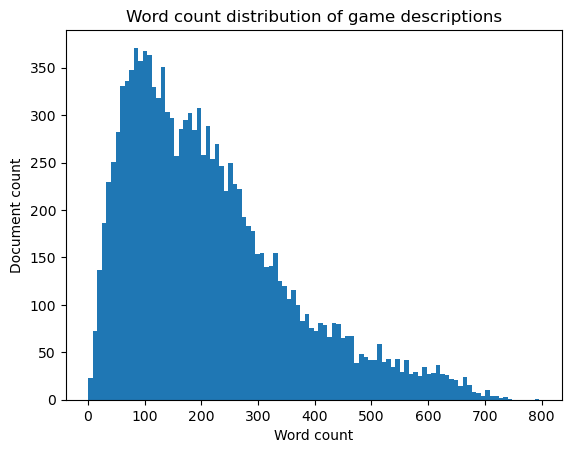

In [28]:
# Histogram about the description lengths
counts, bins = np.histogram(df['WordCounts'], bins=100)
plt.stairs(counts, bins, fill=True)
plt.xlabel('Word count')
plt.ylabel('Document count')
plt.title('Word count distribution of game descriptions')
plt.show()


In [29]:
df.where(df['WordCounts'] == 1)['Description'].dropna()


552917    作業TipOn將學生需要練習的作業數位遊戲化。作業TipOn提供不同的遊戲模組，讓學生可以透...
Name: Description, dtype: object

In [30]:
#most frequent words and info about word distributions
from collections import Counter
from gensim.parsing.preprocessing import remove_stopwords, strip_punctuation, strip_numeric, strip_short, strip_tags

all_text = df['Description'].apply(str.lower).apply(strip_punctuation).apply(remove_stopwords).apply(strip_numeric).apply(strip_tags).apply(strip_short).str.cat(sep=' ').split()

top_words = pd.DataFrame(
    Counter(all_text).most_common(30),
    columns=['word', 'frequency']
)
#top_words




In [31]:
# print out most frequent content words to latex
# https://pandas.pydata.org/docs/reference/api/pandas.io.formats.style.Styler.to_latex.html
print(top_words.style.format({
   ("Non-Numeric", "\textbf{Word}"): str,
   ("Integer", "Frequency"): '{:.3f}'
}).to_latex(hrules=True,
  position="h",
  caption="Most frequent content words in game descriptions",
  position_float="centering",
  column_format="|l|l|",
  label="table:most-frequent-words-in-corpus",
))


\begin{table}[h]
\centering
\caption{Most frequent content words in game descriptions}
\label{table:most-frequent-words-in-corpus}
\begin{tabular}{|l|l|}
\toprule
 & word & frequency \\
\midrule
0 & game & 35367 \\
1 & play & 15149 \\
2 & com & 10571 \\
3 & app & 10354 \\
4 & games & 10204 \\
5 & fun & 9158 \\
6 & new & 8922 \\
7 & free & 7931 \\
8 & time & 7314 \\
9 & features & 6916 \\
10 & world & 5968 \\
11 & levels & 5610 \\
12 & use & 5452 \\
13 & like & 5436 \\
14 & puzzle & 5147 \\
15 & facebook & 5005 \\
16 & friends & 4911 \\
17 & different & 4910 \\
18 & www & 4783 \\
19 & puzzles & 4706 \\
20 & best & 4607 \\
21 & http & 4604 \\
22 & mode & 4317 \\
23 & players & 4288 \\
24 & level & 4039 \\
25 & help & 4001 \\
26 & easy & 3904 \\
27 & iphone & 3811 \\
28 & kids & 3768 \\
29 & enjoy & 3414 \\
\bottomrule
\end{tabular}
\end{table}



## Explorations in genre data

In [32]:
df['AppStoreGenreIds'].describe()


count                  12901
unique                  1616
top       [6014, 7009, 6017]
freq                     213
Name: AppStoreGenreIds, dtype: object

In [33]:
# These mappings are from https://developers.apptweak.com/reference/app-store-categories
# This is used just to check that the genreIds and genres match in the
# response from the app store API

# Note that these mappings are not in the end used as we use the genre names extracted
# from the API directly. It has been part of the exploratory data analysis to inspect whether
# these codes work as expected or not.
category_mappings = {
    '6000': 'Business',
    '6001': 'Weather',
    '6002': 'Utilities',
    '6003': 'Travel',
    '6004': 'Sports',
    '6005': 'Social Networking',
    '6006': 'Reference',
    '6007': 'Productivity',
    '6008': 'Photo & Video',
    '6009': 'News',
    '6010': 'Navigation',
    '6011': 'Music',
    '6012': 'Lifestyle',
    '6013': 'Health & Fitness',
    '6014': 'Games',
    '6015': 'Finance',
    '6016': 'Entertainment',
    '6017': 'Education',
    '6018': 'Books',
    '6020': 'Medical',
    '6021': 'Newsstand',
    '6022': 'Catalogs',
    '6023': 'Food & Drink',
    '6024': 'Shopping',
    '6027': 'Graphics & Design',
    '7001': 'Game Action',
    '7002': 'Game Adventure',
    '7003': 'Game Casual',
    '7004': 'Game Board',
    '7005': 'Game Card',
    '7006': 'Game Casino',
    '7007': 'Game Dice',
    '7008': 'Game Educational',
    '7009': 'Game Family',
    '7010': 'Game Kids',
    '7011': 'Game Music',
    '7012': 'Game Puzzle',
    '7013': 'Game Racing',
    '7014': 'Game Role Playing',
    '7015': 'Game Simulation',
    '7016': 'Game Sports',
    '7017': 'Game Strategy',
    '7018': 'Game Trivia',
    '7019': 'Game Word'
}

# convert the genre ids to genre strings

def convert_genre_id_to_str(id_array):
    genre_strings = [category_mappings[genre_id] for genre_id in id_array]
    return genre_strings

df['convertedAppStoreGenres'] = df['AppStoreGenreIds'].apply(convert_genre_id_to_str)

df[['AppStoreGenres', 'convertedAppStoreGenres']]


,AppStoreGenres,convertedAppStoreGenres
21,"[Games, Role Playing, Adventure, Books]","[Games, Game Role Playing, Game Adventure, Books]"
100,"[Games, Books, Role Playing]","[Games, Books, Game Role Playing]"
118,"[Games, Books, Family]","[Games, Books, Game Family]"
289,"[Games, Puzzle, Books]","[Games, Game Puzzle, Books]"
2333,"[Games, Family, Books]","[Games, Game Family, Books]"
...,...,...
1165471,"[Games, Sports, Sports, Casual]","[Games, Game Sports, Sports, Game Casual]"
1167789,"[Games, Puzzle, Travel, Role Playing]","[Games, Game Puzzle, Travel, Game Role Playing]"
1168772,"[Games, Simulation, Casino, Sports]","[Games, Game Simulation, Game Casino, Sports]"
1197497,"[Games, Simulation, Utilities]","[Games, Game Simulation, Utilities]"


Statistics about number of genres from the app store metadata
mean    2.545074
min     0.000000
max     3.000000
std     0.631047
Name: AppStoreGenres, dtype: float64
(array([0, 1, 2, 3]), array([  51,  816, 4084, 7950]))


<AxesSubplot:>

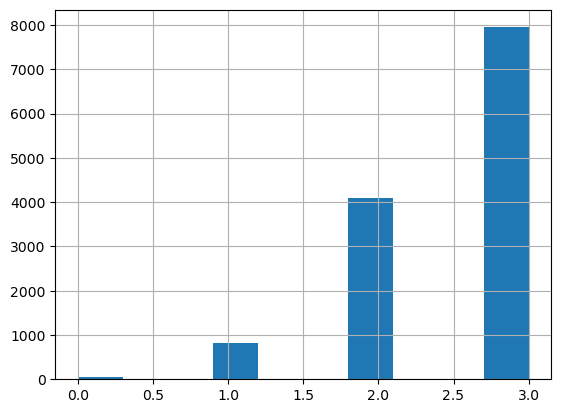

In [34]:
# -1 removes the shared 'Games' category that is included in every item
print("Statistics about number of genres from the app store metadata")
print((df['AppStoreGenres'].str.len()-1).agg(['mean','min', 'max','std']))


# Get counts of different number of genres listed for games
print(np.unique((df['AppStoreGenres'].str.len()-1), return_counts=True))
# draw histogram of the above
(df['AppStoreGenres'].str.len()-1).hist()


In [35]:
all_categories = np.array(sum(df['AppStoreGenres'].values.tolist(), []))
# convert codes to readable categories
all_categories = list(filter(lambda x : x != 'Games', all_categories))
# drop the Game category since it's in all items



<AxesSubplot:title={'center':'Distribution of App Store genre labels'}, xlabel='Genre'>

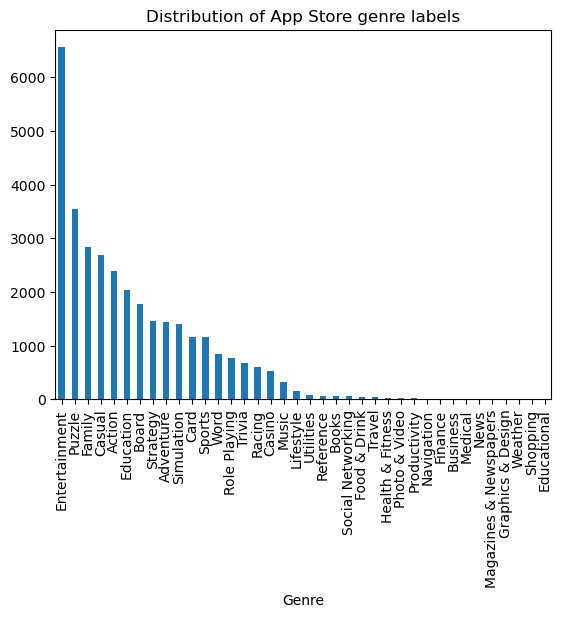

In [36]:
categories_df = pd.Series(all_categories, dtype='category')

categories_df.value_counts().plot.bar(title='Distribution of App Store genre labels', xlabel='Genre')


#plt.hist(all_categories, bins=len(set(all_categories)), fill=True)
#plt.xlabel('Genre')
#plt.xticks(rotation=90)
#plt.title('Distribution of App Store genre labels')
#plt.show()


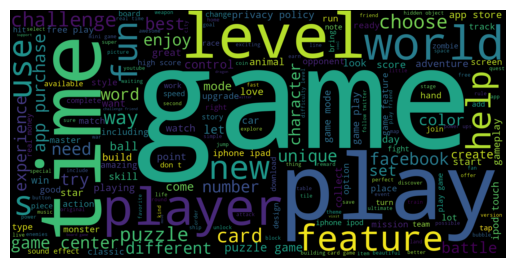

: 

In [65]:
# Generate word cloud from all the documents
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# get the descriptions
text = df['PreprocessedDescription'].to_list()
#combine the list into a single item
text = "".join(text)

# This word cloud gives some idea how generic the original text
#wordcloud = WordCloud().generate(text)
wordcloud = WordCloud(width=800, height=400, scale=2).generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
